# 偏差和方差

此Notebook是配合Andrew Ng \"Machine Leanring\"中[打造实用的机器学习系统](https://github.com/loveunk/machine-learning-deep-learning-notes/blob/master/machine-learning/advice-for-appying-and-system-design.md)部分学习使用。

测试用Python版本为3.6
* 机器学习路径：https://github.com/loveunk/machine-learning-deep-learning-notes/
* 内容正文综合参考网络资源，使用中如果有疑问请联络：https://www.kaikai.ai

In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data():
    """
    说明：d['X'] shape = (12, 1)，使用 np.ravel 把它们 flattern 为 vector
    """
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [3]:
X, y, Xval, yval, Xtest, ytest = load_data()

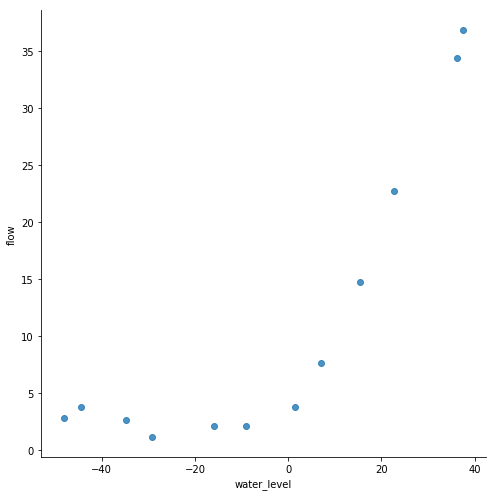

In [4]:
df = pd.DataFrame({'water_level':X, 'flow':y})

sns.lmplot('water_level', 'flow', data=df, fit_reg=False, height=7)
plt.show()

In [5]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

# 代价函数

代价函数公式：
$$J(\theta)=\frac{1}{2m}\sum_{i=1}^m\left(h_{\theta}(x^{(i)})-y^{(i)}\right)^2$$

In [6]:
def cost(theta, X, y):
    """
    X: R(m*n), m records, n features
    y: R(m)
    theta : R(n), linear regression parameters
    """
    m = X.shape[0]

    inner = X @ theta - y  # R(m*1)

    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [7]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

# 输出值约为 303.951

303.9515255535976

# 正则化代价函数

正则化代价函数公式：
$$J(\theta)=\frac{1}{2m}\left(\sum_{i=1}^m\left(h_{\theta}(x^{(i)})-y^{(i)}\right)^2\right) + \dfrac{\lambda}{2m}\left(\sum_{j=1}^n \theta_j^2\right)$$

In [8]:
def regularized_cost(theta, X, y, l=1):
    """
    X: R(m*n), m records, n features
    y: R(m)
    theta : R(n), linear regression parameters
    l: lambda constant for regularization
    """
    m = X.shape[0]

    inner = X @ theta - y  # R(m*1)
    
    cost = (inner.T @ inner) / (2 * m) 

    regularized_term = np.sum(theta[1:]**2) * l / (2 * m)

    return cost + regularized_term

In [9]:
theta = np.ones(X.shape[1])
regularized_cost(theta, X, y)

# 输出值约为 303.993

303.9931922202643

# 梯度

梯度下降公式：
$$\theta_j := \theta_j - \alpha \dfrac {\partial }{\partial \theta _{j}} J(\theta)$$

In [10]:
def gradient(theta, X, y):
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)

    return inner / m

In [11]:
gradient(theta, X, y)

# 输出值约为 array([-15.30301567, 598.16741084])

array([-15.30301567, 598.16741084])

# 正则化梯度

正则化梯度公式：
$$
\begin{align*}
&\dfrac {\partial J(\theta)}{\partial \theta _{0}} = \dfrac{1}{m} \sum_{i=1}^m \left(h_\theta(x^{(i)}) - y^{(i)}\right)x_j^{(i)} & \text{for } j=0 \\
&\dfrac {\partial J(\theta)}{\partial \theta _{0}} = \left(\dfrac{1}{m} \sum_{i=1}^m \left(h_\theta(x^{(i)}) - y^{(i)}\right)x_j^{(i)}\right) + \dfrac{\lambda}{m}\theta_j & \text{for } j \ge 1
\end{align*}
$$

In [12]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta

    regularized_term = (l / m) * regularized_term

    return gradient(theta, X, y) + regularized_term

In [13]:
regularized_gradient(theta, X, y)

# 输出值约为 array([ -15.30301567,  598.25074417])

array([-15.30301567, 598.25074417])

# 拟合数据
> 正则化项 $\lambda=0$

In [14]:
def linear_regression_np(X, y, l=1):
    """linear regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.ones(X.shape[1])

    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    return res

In [15]:
theta = np.ones(X.shape[0])

final_theta = linear_regression_np(X, y, l=0).get('x')

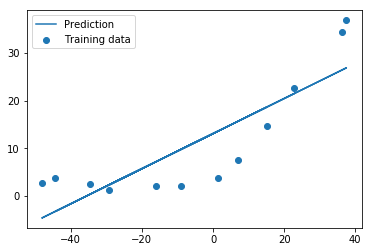

In [16]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

In [17]:
training_cost, cv_cost = [], []

1.使用训练集的子集来拟合应模型

2.在计算训练代价和交叉验证代价时，没有用正则化

3.记住使用相同的训练集子集来计算训练代价

In [18]:
m = X.shape[0]
for i in range(1, m+1):
    # print('i={}'.format(i))
    res = linear_regression_np(X[:i, :], y[:i], l=0)
    
    # train cost
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    
    # cross-validation cost
    cv = regularized_cost(res.x, Xval, yval, l=0)
    # print('tc={}, cv={}'.format(tc, cv))
    
    training_cost.append(tc)
    cv_cost.append(cv)

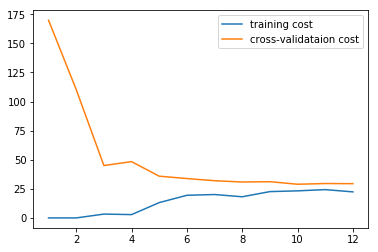

In [19]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cross-validataion cost')
plt.legend(loc=1)
plt.show()

这个模型拟合不太好, **欠拟合了**

# 创建多项式特征

In [20]:
def prepare_poly_data(*args, power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
    """
    def prepare(x):
        # expand feature
        df = poly_features(x, power=power)

        # normalization
        ndarr = normalize_feature(df).values

        # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [21]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.values if as_ndarray else df


In [22]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [23]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


# 准备多项式回归数据
1. 扩展特征到 8阶,或者你需要的阶数
2. 使用 **归一化** 来合并 $x^n$ 
3. don't forget intercept term

In [24]:
def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [25]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

# 画出学习曲线
## 尝试不使用正则化 $\lambda=0$

In [26]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        # regularization applies here for fitting parameters
        res = linear_regression_np(X[:i, :], y[:i], l=l)

        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)


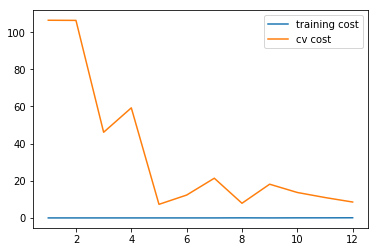

In [27]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

你可以看到训练的代价太低了，不真实. 这是 **过拟合**了

## 尝试 $\lambda=1$

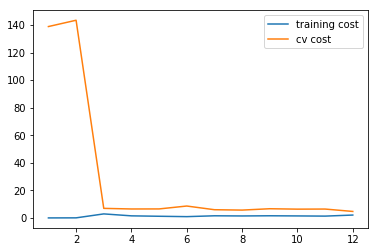

In [28]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()

训练代价增加了些，不再是0了，也就是说减轻了**过拟合**

## 尝试 $\lambda=100$

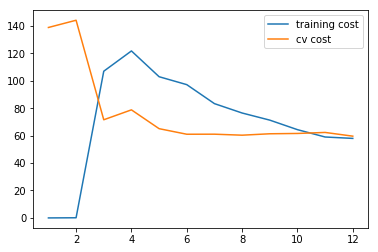

In [29]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

正则化过度了，成了 **欠拟合**状态

## 找到最佳的 $\lambda$

In [30]:
# 尝试一系列的labmda值
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [31]:
for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

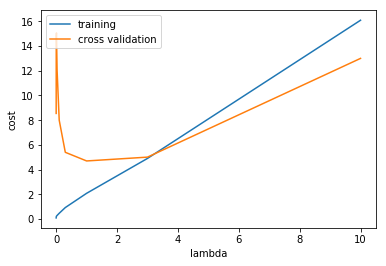

In [32]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=2)

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

In [33]:
# 使用cross-validation cost找到最佳的lambda，即cross-validation cost最小时的lambda
l_candidate[np.argmin(cv_cost)]

1

In [34]:
# 使用测试数据来计算 cost
test_cost = []
for l in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    tc = cost(theta, Xtest_poly, ytest)
    test_cost.append(tc)
    print('test cost(l={}) = {}'.format(l, tc))

test cost(l=0) = 10.804375286491785
test cost(l=0.001) = 10.911365745177878
test cost(l=0.003) = 11.265060784108712
test cost(l=0.01) = 10.879143763702967
test cost(l=0.03) = 10.022378551698187
test cost(l=0.1) = 8.631776100446476
test cost(l=0.3) = 7.3365081011786275
test cost(l=1) = 7.466282452677015
test cost(l=3) = 11.643940740451052
test cost(l=10) = 27.715080273166386


调参后， $\lambda = 0.3$ 是最优选择，这个时候测试代价最小。
打印出来看看：

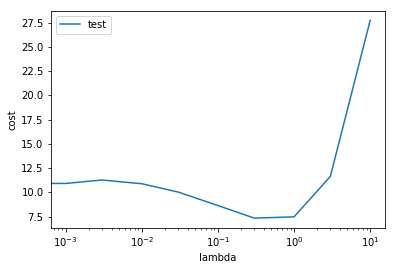

In [35]:
plt.semilogx(l_candidate, test_cost, label='test')
plt.legend(loc=2)
plt.xlabel('lambda')
plt.ylabel('cost')
plt.show()